<a href="https://colab.research.google.com/github/dancher00/Experimental-Data-Analysis/blob/main/EKF_for_navigation_and_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 8
## Extended Kalman filter for navigation and tracking

Team 1:
- **Danil Belov**
- **Alexey Kotcov**
- **Roman Khalikov**

During this assignment we worked equally together as a team achieving the best efficiency ever

zur Unendlichkeit und darüber hinaus!

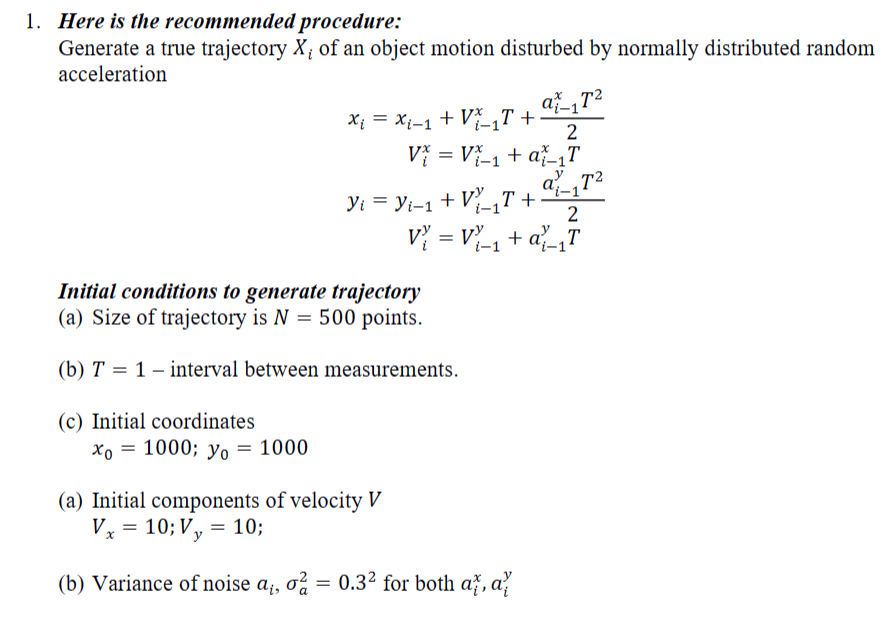

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(44)

In [ ]:


x_0 = 1000

v_0 = 10

t = 1
n = 500

sigma_a = 0.3

sigma_d = 50
sigma_b = 0.004

In [ ]:
def generate_trajectory(n, x_0, v_0, sigma_a, sigma_d, sigma_b):

    a = np.random.normal(0, sigma_a, size = (n, 2))
    v = np.zeros((n, 2))
    x = np.zeros((n, 2))

    v[0] = [v_0, v_0]
    x[0] = [x_0, x_0]

    for i in range(1, n):
        v[i] = v[i-1] + a[i-1] * t

    for i in range(1, n):
        x[i] = x[i-1] + v[i-1] * t + a[i-1] * t**2 /2

    x_ = x.T

    d = np.sqrt(np.sum(x_**2, axis=0))
    b = np.arctan2(x_[0], x_[1])

    d_m = d + np.random.normal(0, sigma_d, len(d))
    b_m = b + np.random.normal(0, sigma_b, len(b))

    z_p = np.array([d_m, b_m])
    z_c = np.array([d_m * np.sin(b_m), d_m * np.cos(b_m)])

    return x_, d, b, z_p, z_c

According to the task, we generate **coordinates** and **velocity**. And additionally generate measurements **range d** and **azimuth beta**.

In [ ]:
x_, d, b, z_p, z_c = generate_trajectory(n, x_0, v_0, sigma_a, sigma_d, sigma_b)

In [ ]:
F = np.eye(4)
F[0,1] = t
F[2,3] = t

G = np.zeros((4,2))
G[0,0] = t**2 / 2
G[1,0] = t
G[2,1] = t**2 / 2
G[3,1] = t

Q = G @ G.T * sigma_a**2

R = np.zeros((2,2))
R[0,0] = sigma_d**2
R[1,1] = sigma_b**2

Transition matrix **F**, state noise matrix **Q** and noise covariance matrix **R** according to formulas

In [ ]:
def h(x):
  return np.array([[np.sqrt(x[0][0]**2 + x[2][0]**2)],
                   [  np.arctan2(x[0][0], x[2][0])  ]])

def dh(x):
  return np.array([[x[0][0]/np.sqrt(x[0][0]**2 + x[1][0]**2), 0, x[2][0] / np.sqrt(x[0][0]**2 + x[1][0]**2), 0],
                   [x[2][0]/(x[0][0]**2 + x[1][0]**2),        0, -x[0][0]/(x[0][0]**2 + x[1][0]**2),         0]])

Special linearization formulas just for convenience later

In [ ]:
def kalman(z_p, z_c):

    x_k = np.zeros((n, 4))

    K_arr = np.zeros(n)

    d_ext = np.zeros(n, dtype='float64')
    b_ext = np.zeros(n, dtype='float64')
    d_fil = np.zeros(n, dtype='float64')
    b_fil = np.zeros(n, dtype='float64')

    X = np.array(([z_p[0][0] * np.sin(z_p[1][0])],
                            [0],
                  [z_p[0][0] * np.cos(z_p[1][0])],
                            [0]                  ))


    P_fil = np.eye(4) * 10**10

    for i in range(n):
        X = F @ X
        P_pred = F @ P_fil @ F.T + Q

        H = dh(X)

        d_ext[i] = np.sqrt(X[0]**2 + X[2]**2)
        b_ext[i] = np.arctan2(X[0], X[2])

        # print((H @ P_pred @ H.T + R))
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
        P_fil = (np.eye(np.shape(P_pred)[0]) - K @ H) @ P_pred
        X = X + K @ (z_p[:,i:(i+1)] - h(X))

        d_fil[i] = np.sqrt(X[0]**2 + X[2]**2)
        b_fil[i]= np.arctan2(X[0], X[2])

        x_k[i] = X.T
        K_arr[i] = K[0][0]

    return d_ext, b_ext, d_fil, b_fil

There it is! Here we have range D predictions, azimuth beta predictions and its filtrations!

In [ ]:
d_ext_arr, b_ext_arr, d_fil_arr, b_fil_arr = kalman(z_p, z_c)

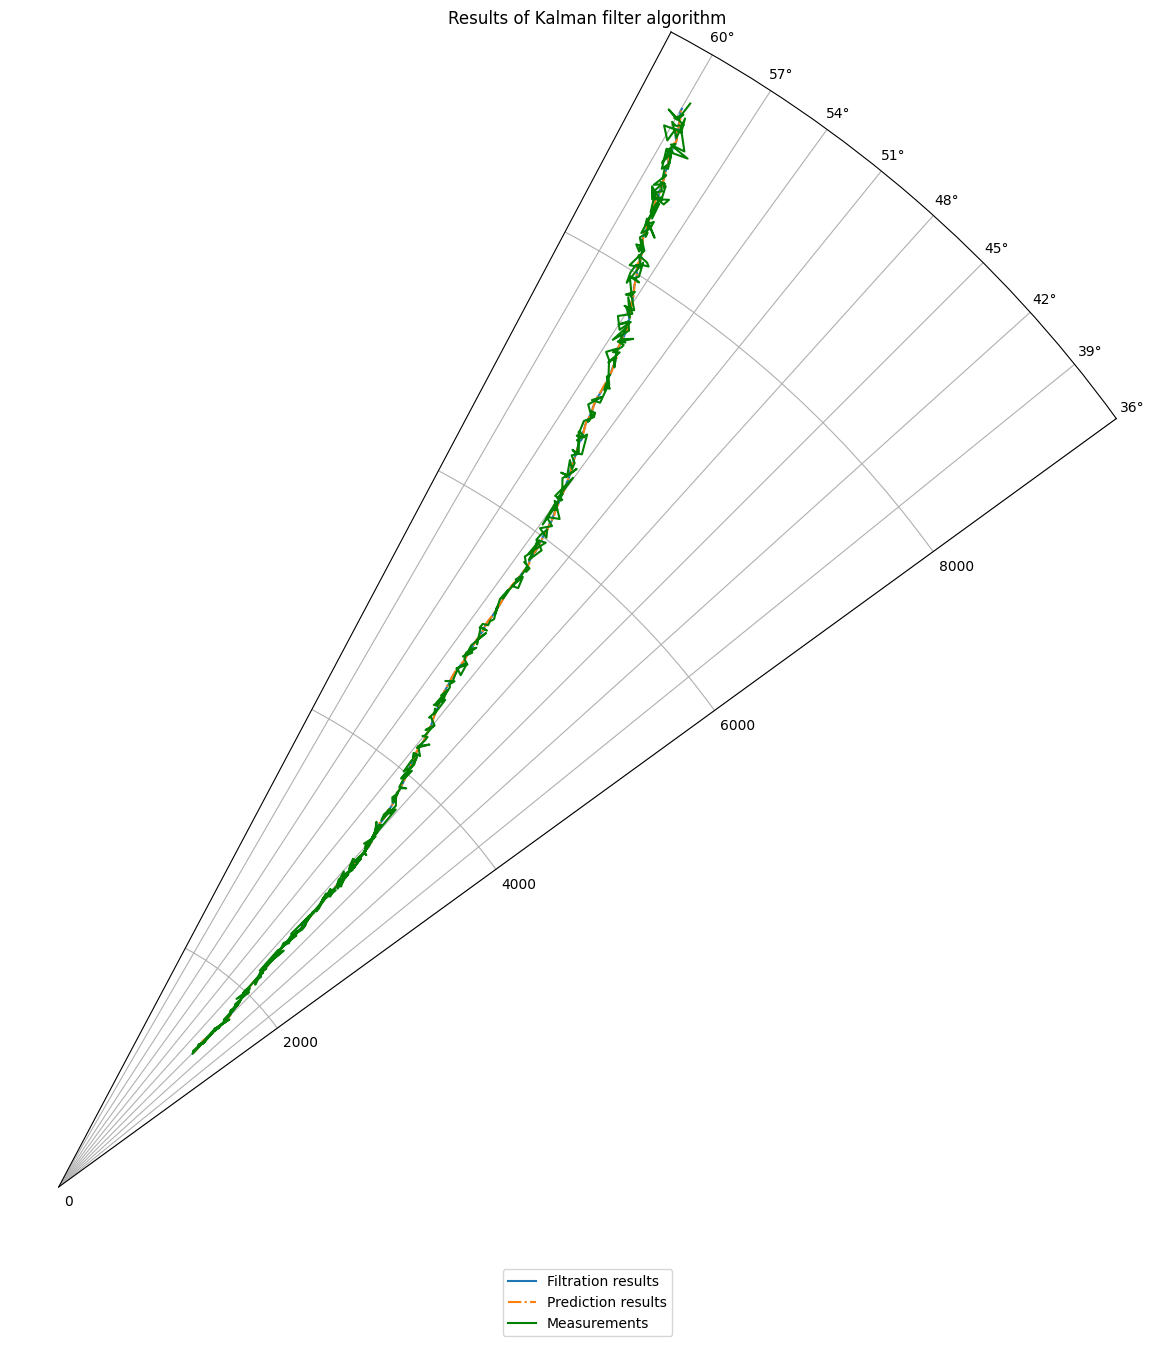

In [ ]:
plt.figure(figsize = (15,15))
plt.polar(b_fil_arr, d_fil_arr, label = 'Filtration results')
plt.polar(b_ext_arr, d_ext_arr, label = 'Prediction results', linestyle='dashdot')
plt.polar(z_p[1], z_p[0], color='g', label='Measurements')
plt.xlim([np.pi/5,np.pi/2.9])

plt.title('Results of Kalman filter algorithm')
plt.legend(loc='center', bbox_to_anchor=(0.5,-0.1))
plt.show()

As we can see from the plot, filtration and prediction results are almost the same

In [ ]:
M = 500

error_D_ext =  np.zeros(M)
error_D_fil =  np.zeros(M)

error_b_ext =  np.zeros(M)
error_b_fil =  np.zeros(M)

error_meas_D =  np.zeros(M)
error_meas_b =  np.zeros(M)

for i in range(M):


    x_, d, b, z_p, z_c = generate_trajectory(n, x_0, v_0, sigma_a, sigma_d, sigma_b)
    d_ext_arr, b_ext_arr, d_fil_arr, b_fil_arr = kalman(z_p, z_c)



    error_D_ext += (d_ext_arr - z_p[0])**2
    error_D_fil += (d_fil_arr - z_p[0])**2

    error_b_ext += (b_ext_arr - z_p[1])**2
    error_b_fil += (b_fil_arr - z_p[1])**2

    error_meas_D += (z_p[0] - d)**2
    error_meas_b += (z_p[1] - b)**2


error_D_ext_f = np.sqrt((error_D_ext)/(M-1))[2:]
error_D_fil_f = np.sqrt((error_D_fil)/(M-1))[2:]

error_b_ext_f = np.sqrt((error_b_ext)/(M-1))[2:]
error_b_fil_f = np.sqrt((error_b_fil)/(M-1))[2:]

error_meas_D_f = np.sqrt((error_meas_D)/(M-1))[2:]
error_meas_b_f = np.sqrt((error_meas_b)/(M-1))[2:]

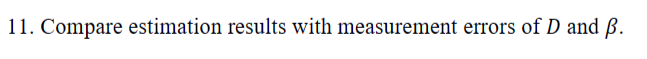

**Lets plot our final error values!**

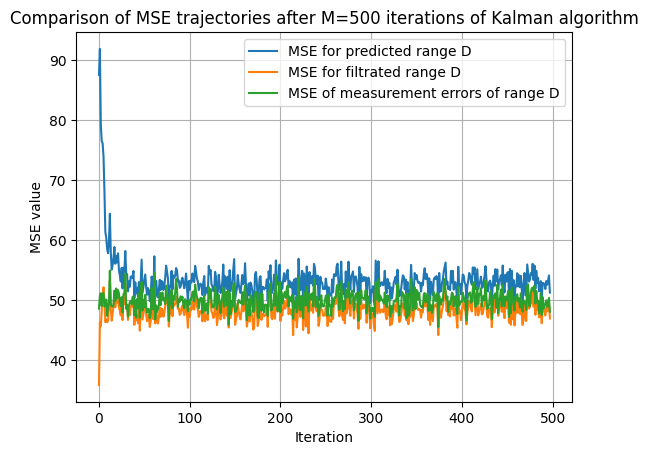

In [ ]:
plt.plot(error_D_ext_f)
plt.plot(error_D_fil_f)
plt.plot(error_meas_D_f)
plt.legend(['MSE for predicted range D','MSE for filtrated range D','MSE of measurement errors of range D'])
plt.title('Comparison of MSE trajectories after M=500 iterations of Kalman algorithm')
plt.xlabel('Iteration')
plt.ylabel('MSE value')
plt.grid()
plt.show()

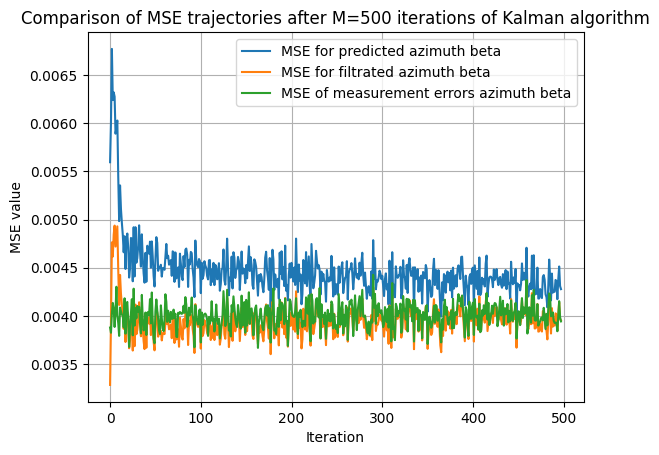

In [ ]:
plt.plot(error_b_ext_f)
plt.plot(error_b_fil_f)
plt.plot(error_meas_b_f)
plt.legend(['MSE for predicted azimuth beta','MSE for filtrated azimuth beta','MSE of measurement errors azimuth beta'])
plt.title('Comparison of MSE trajectories after M=500 iterations of Kalman algorithm')
plt.xlabel('Iteration')
plt.ylabel('MSE value')
plt.grid()
plt.show()

It looks a little bit dirty, lets make it clear

In [ ]:
def runMean(row):
    cur_row = row.copy()
    for i in range(6, len(row)-6):
        cur_row[i] = row[(i-5):(i+6)].sum() / 12 + (row[i-6]+row[i+6]) / 24
    return cur_row

In [ ]:
smooth_b_ext_f = runMean(error_b_ext_f)
smooth_b_fil_f = runMean(error_b_fil_f)
smooth_D_ext_f = runMean(error_D_ext_f)
smooth_D_fil_f = runMean(error_D_fil_f)
smooth_error_m_b = runMean(error_meas_b_f)
smooth_error_m_d = runMean(error_meas_D_f)

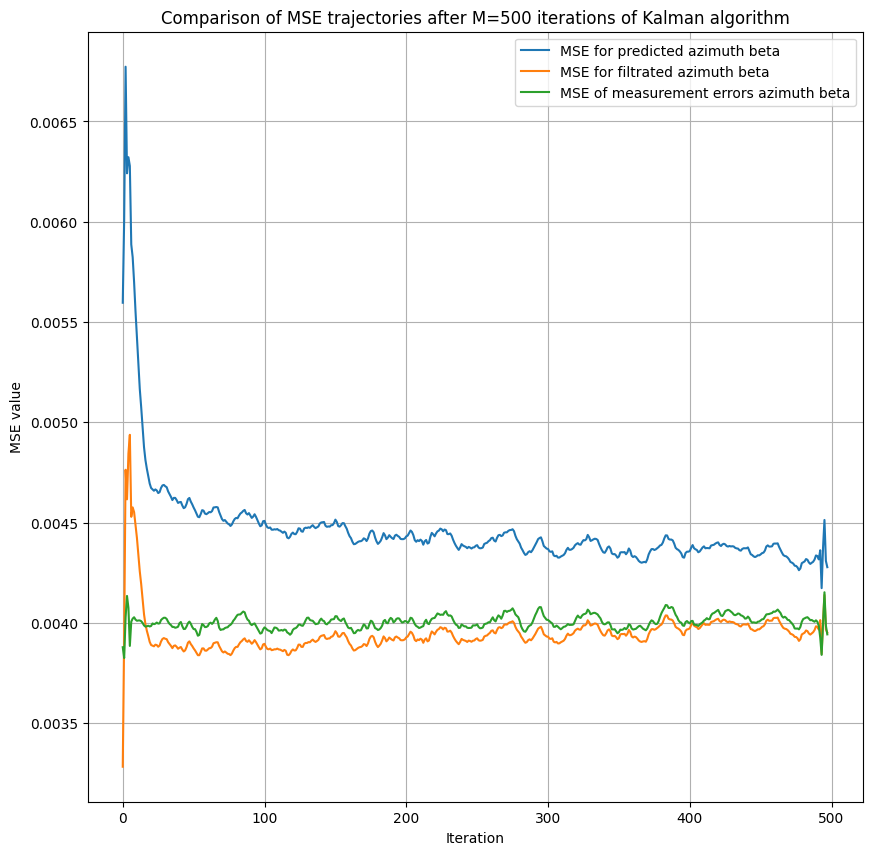

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(smooth_b_ext_f)
plt.plot(smooth_b_fil_f)
plt.plot(smooth_error_m_b)
plt.legend(['MSE for predicted azimuth beta','MSE for filtrated azimuth beta','MSE of measurement errors azimuth beta'])
plt.title('Comparison of MSE trajectories after M=500 iterations of Kalman algorithm')
plt.xlabel('Iteration')
plt.ylabel('MSE value')
plt.grid()
plt.show()

Now much better. Looking at the graph we can notice that MSE of filtration values are less than prediction one and peak at the start which corresponds to initial values that equals measurements values. We can see that our Kalman algorithm **performed lowering of measurement errors**.

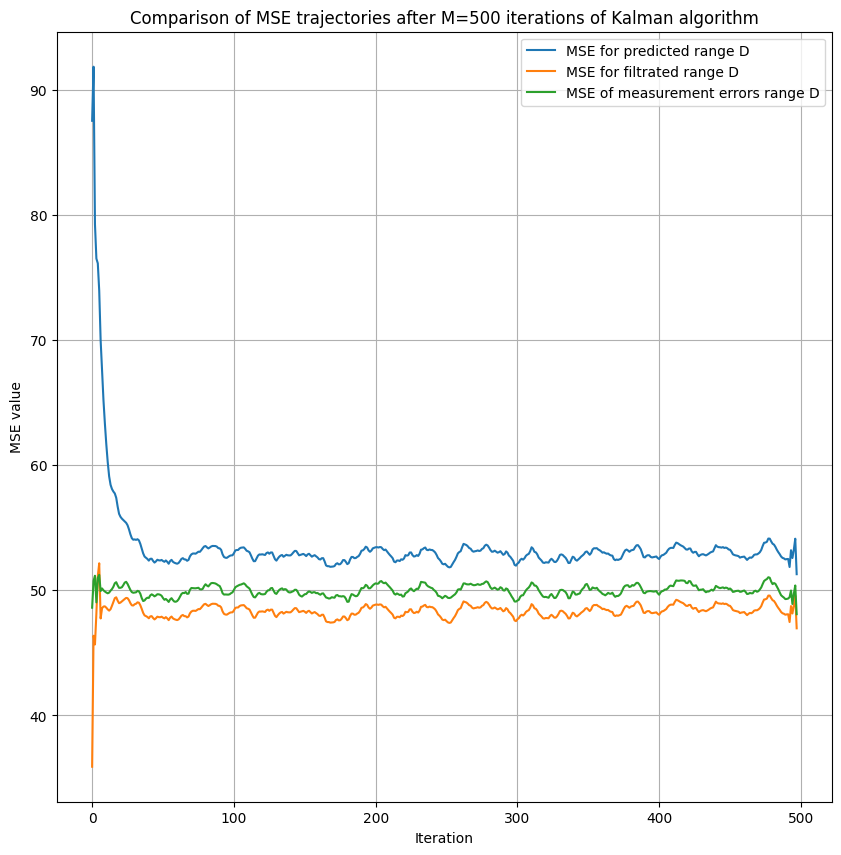

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(smooth_D_ext_f)
plt.plot(smooth_D_fil_f)
plt.plot(smooth_error_m_d)
plt.legend(['MSE for predicted range D','MSE for filtrated range D','MSE of measurement errors range D'])
plt.title('Comparison of MSE trajectories after M=500 iterations of Kalman algorithm')
plt.xlabel('Iteration')
plt.ylabel('MSE value')
plt.grid()
plt.show()

Almost the same picture for MSE final range D

**Conclusions**: in this assignment we dived deeper in filtering and predicting in polar coordinates, that linearizing measurement part at every filtering step was **especially hard**, because from the slide formulas was not quite clear how to transfer that into set of numpy calculations, but **we did it!**. And new thing for us was **designing** of the plots in **polar coordinates.**
After the running algorithm for **M=500 iterations**, we plotted MSE comparison graph for range D and azimuth beta with measurements error, from which we noticed that: **1)** MSE of filtrated values just a little bit lower than measurement errors; **2)** MSE of predicted values higher than measurement errors.